In [1]:
from time import time
import os
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_skipc import ChromosomeSkip, FitnessSkip, Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA
from time import time
import numpy as np

Using TensorFlow backend.


In [2]:
# Chromosome parameters
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2
ChromosomeCNN.grow_prob = mutation_rate
ChromosomeCNN.decrease_prob = mutation_rate

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1

'''
data_folder = '../datasets'
command = 'python3 ./train_gen.py'
verbose = 0
experiments_folder = '../exps3'
gpus = 2

'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./train_gen.py'
verbose = 1
experiments_folder = '../exps4'
gpus = 1
skip = True

In [8]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

if skip:
    fitness_cnn = FitnessSkip()
else:
    fitness_cnn = FitnessCNN()

l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness_cnn)
if skip:
    c = ChromosomeSkip(c.cnn_layers, c.nn_layers, Connections.random_connections(len(c.cnn_layers)))
    
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.25 * 2
generations = 2
population = 2
train_time = 10
maximize_fit = False
stat_val = False
save_progress = False
age_survivors_rate = 0.05
precision_val = True
precision_individuals=1

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(population//4)}
p = ps[parents_selector_key]

# Fitness params
epochs = 2
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 15
warm_up_epochs= 0
base_lr = 0.001
smooth = 0.1
cosine_dec = True
lr_find = False
precise_eps = 5

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['MRDBI']

1
11




EVOLVING IN DATASET MRDBI ...

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 2
Population size: 2
num parents: 1
offspring size: 1

Creating Initial population

Start evolution process...

Training... MAXPOOL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 110

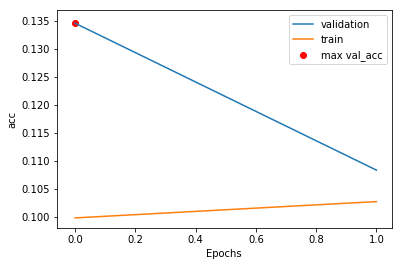

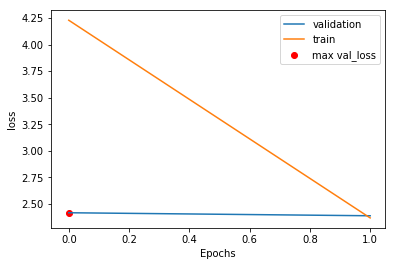

0.8654 in 2.7 min

Training... MAXPOOL
MAXPOOL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 243)  2430        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 243)  972         conv2d_1[0][0]                   
______________________________________________________________

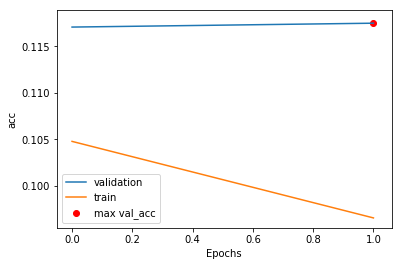

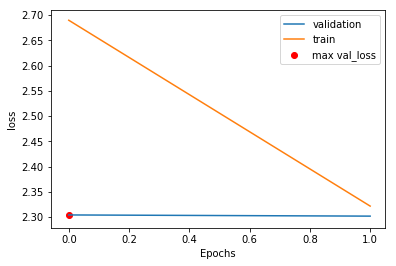

0.8825 in 1.5 min

Training... MAXPOOL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 110)  660         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 110)  440         conv2d_1[0][0]                   
______________________________________________________________________

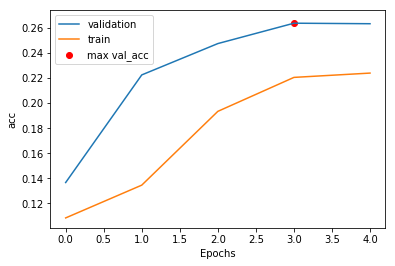

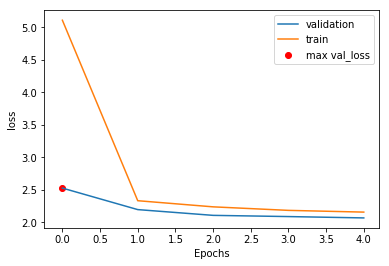

0.7363 in 3.7 min

1) best fit: 0.736 in batch time: 7.85 mins
Current winner:
CNN|F:110|K:(5,1)|A:tanh|D:0.416|M:0
CNN|F:77|K:(7,3)|A:prelu|D:0.370|M:0
CNN|F:132|K:(3,1)|A:relu|D:0.578|M:0
CNN|F:132|K:(3,3)|A:sigmoid|D:0.649|M:1
NN|U:55|A:elu|D:0.085
1
01
101



ValueError: attempt to get argmin of an empty sequence

In [9]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    
    generational = GenerationalGA(fitness=fitness_cnn, num_parents=num_parents, chromosome=c, parent_selector=p,
                              generations=generations, num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                              save_progress=save_progress, age_survivors_rate=age_survivors_rate,
                              precision_val=precision_val, precision_individuals=precision_individuals)
    
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
generational = GenerationalGA.load_genetic_algorithm(folder=folder)

In [ ]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
